In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize as sklearn_normalize
from sklearn.utils import shuffle
from tensorflow import keras

np.random.seed(1)

In [2]:
def normalize(x):
    return (np.array(x) - 0) / (3000 - 0)

## Load data and make predictions

In [3]:
train_data_dir = '../data/training_sites'

with open(os.path.join(train_data_dir, "negative_data.pkl"), 'rb') as file:
    x_negative = pickle.load(file)
file.close()
y_negative = np.zeros(len(x_negative))

with open(os.path.join(train_data_dir, "positive_data.pkl"), 'rb') as file:
    x_positive = pickle.load(file)
file.close()
y_positive = np.ones(len(x_positive))

with open(os.path.join(train_data_dir, "positive_data_test.pkl"), 'rb') as file:
    x_positive_test = pickle.load(file)
file.close()
y_positive_test = np.ones(len(x_positive_test))

x = np.concatenate((x_positive, x_negative))
y = np.concatenate((y_positive, y_negative))

x, y = shuffle(x, y, random_state=42)
x = normalize(x)
x_positive_test = normalize(x_positive_test)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print("Num Train:\t\t", len(x_train))
print("Num Test:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test == 0.0) / len(y_test):.1f}")

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_positive_test = np.expand_dims(x_positive_test, -1)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_positive_test = keras.utils.to_categorical(y_positive_test, num_classes)

Num Train:		 269434
Num Test:		 67359
Percent Negative Train:	 83.5
Percent Negative Test:	 83.6


In [5]:
model = keras.models.load_model('../models/model_filtered-12-06-2020.h5')

In [6]:
num_test_set_samples = 5000
random_test_indices = np.random.choice(len(x_test), num_test_set_samples)

inputs = np.concatenate((x_positive_test, x_test[random_test_indices]))
preds = model.predict(inputs)
labels = np.concatenate((y_positive_test, y_test[random_test_indices]))

In [7]:
rgb = []
for sample in inputs:
    sample_rgb = np.zeros((1,1,3))
    sample_rgb[0,0,:] = [sample[3], sample[2], sample[1]]
    rgb.append(sample_rgb)
rgb_min = np.array(rgb).min()
rgb_max = np.array(rgb).max()
rgb = np.array([(np.array(element) - rgb_min) / (rgb_max - rgb_min) for element in rgb])

In [8]:
def plot_rgb_hist(rgb, gamma, title):
    colors = ['C0', 'red', 'green']
    plt.figure(figsize=(8,5), dpi=100, facecolor=(1,1,1))
    for channel in range(3):
        plt.hist((np.array(rgb)[:,0,0, 2 - channel]) ** gamma, 
                 bins=len(rgb) // 100, 
                 facecolor=colors[channel], 
                 alpha=0.55)
    plt.title(title + ' - Gamma ' + str(gamma))
    plt.show()

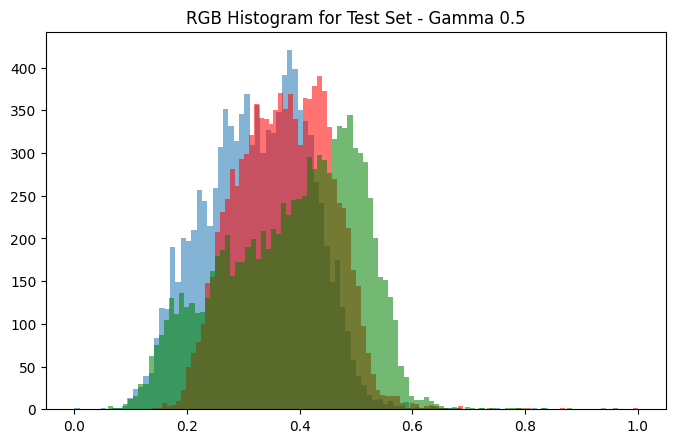

In [9]:
plot_rgb_hist(rgb, 0.5, 'RGB Histogram for Test Set')

## Compile TP, FP, TN, FN classes

In [10]:
THRESHOLD = 0.90

In [11]:
def isolate_category(labels, preds, label_class, pred_class):
    class_index = []
    for label, pred in zip(labels, preds):
        binary_pred = pred[1] > THRESHOLD
        label = label[1]
        if label == label_class and binary_pred == pred_class:
            class_index.append(1)
        else:
            class_index.append(0)
    return np.array(class_index).astype('bool')

In [12]:
tp_index = isolate_category(labels, preds, 1, 1)
tn_index = isolate_category(labels, preds, 0, 0)
fp_index = isolate_category(labels, preds, 0, 1)
fn_index = isolate_category(labels, preds, 1, 0)

print(f"True Positive Rate: {100 * sum(tp_index) / sum(labels[:,1] == 1):.1f}%")
print(f"True Negative Rate: {100 * sum(tn_index) / sum(labels[:,1] == 0):.1f}%")

True Positive Rate: 44.5%
True Negative Rate: 96.0%


## Evaluate spectral profiles of classification categories

In [13]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

band_wavelengths = [442, 492, 559, 665, 704, 739, 779, 833, 864, 943, 1610, 2186]

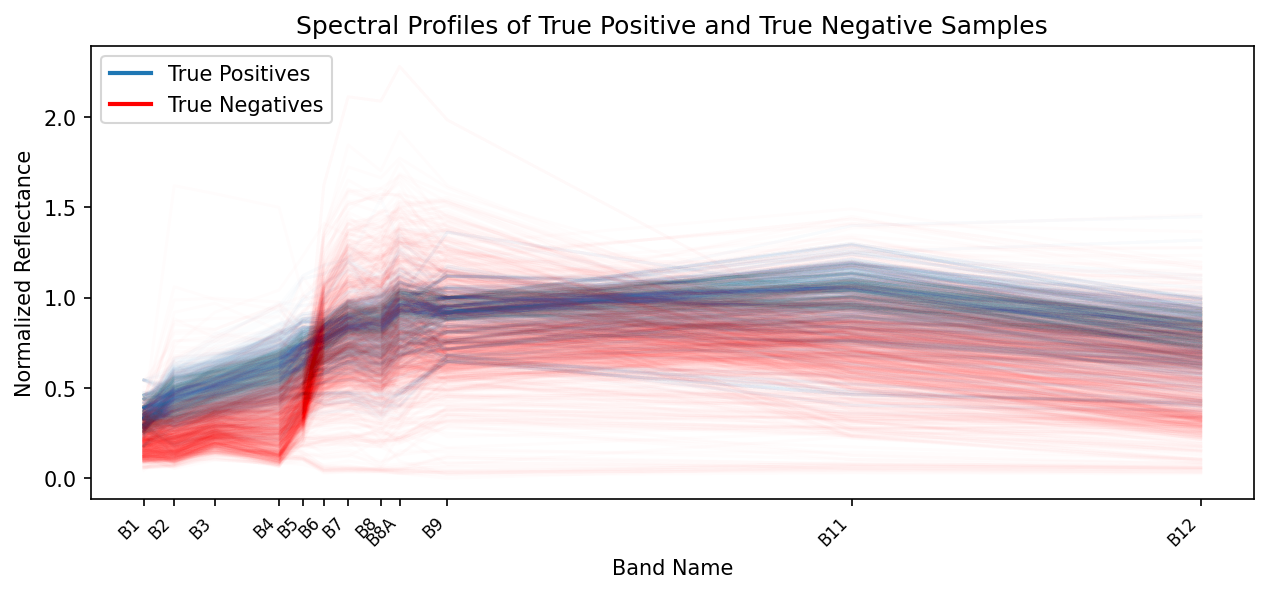

In [14]:
num_samples = 1000

plt.figure(figsize=(10,4), dpi=150, facecolor=(1,1,1))

for reflectance in inputs[tp_index][:num_samples]:
    plt.plot(band_wavelengths, reflectance, c='C0', alpha=0.01)

for reflectance in inputs[tn_index][:num_samples]:
    plt.plot(band_wavelengths, reflectance, c='r', alpha=0.01)

plt.xticks(band_wavelengths, band_descriptions.keys(), ha='right', rotation=45, size=8)
plt.xlabel('Band Name')
plt.ylabel('Normalized Reflectance')
    
legend_lines = [Line2D([0], [0], color='C0', lw=2),
                Line2D([0], [0], color='r', lw=2)]
plt.legend(legend_lines, ['True Positives', 'True Negatives'], loc='upper left')

plt.title('Spectral Profiles of True Positive and True Negative Samples')
plt.show()

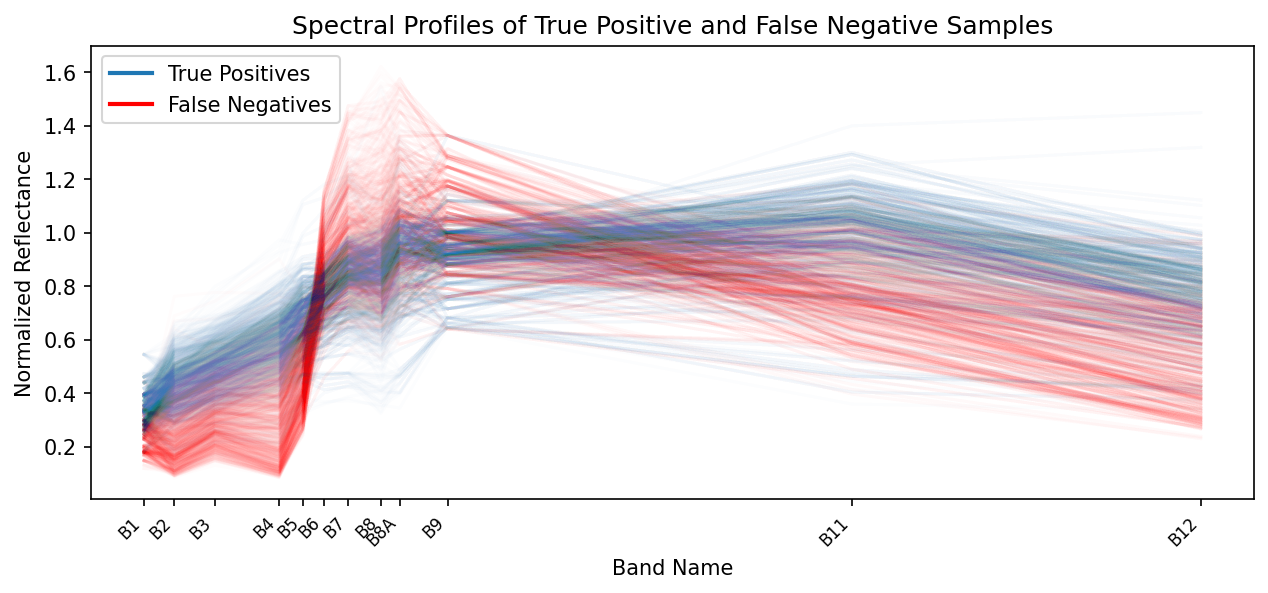

In [15]:
num_samples = 1000

plt.figure(figsize=(10,4), dpi=150, facecolor=(1,1,1))

for reflectance in inputs[fn_index][:num_samples]:
    plt.plot(band_wavelengths, reflectance, c='r', alpha=0.01)

for reflectance in inputs[tp_index][:num_samples]:
    plt.plot(band_wavelengths, reflectance, c='C0', alpha=0.01)

plt.xticks(band_wavelengths, band_descriptions.keys(), ha='right', rotation=45, size=8)
plt.xlabel('Band Name')
plt.ylabel('Normalized Reflectance')
    
legend_lines = [Line2D([0], [0], color='C0', lw=2),
                Line2D([0], [0], color='r', lw=2)]
plt.legend(legend_lines, ['True Positives', 'False Negatives'], loc='upper left')

plt.title('Spectral Profiles of True Positive and False Negative Samples')
plt.show()

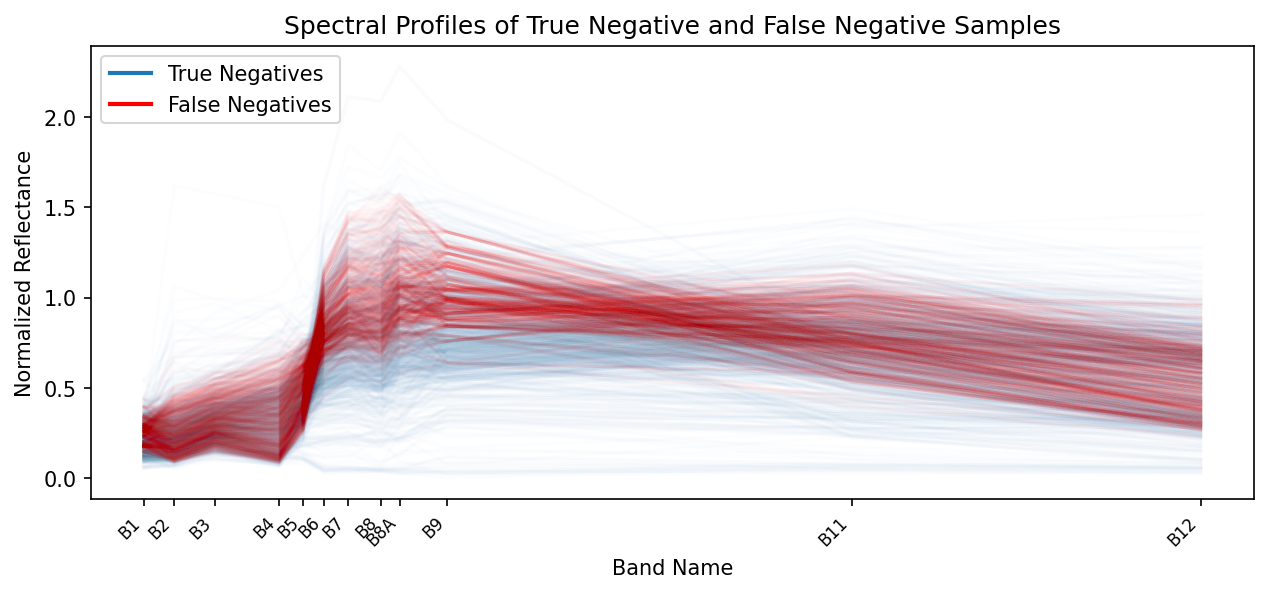

In [16]:
num_samples = 1000

plt.figure(figsize=(10,4), dpi=150, facecolor=(1,1,1))

for reflectance in inputs[tn_index][:num_samples]:
    plt.plot(band_wavelengths, reflectance, c='C0', alpha=0.01)
    
for reflectance in inputs[fn_index][:num_samples]:
    plt.plot(band_wavelengths, reflectance, c='r', alpha=0.01)

plt.xticks(band_wavelengths, band_descriptions.keys(), ha='right', rotation=45, size=8)
plt.xlabel('Band Name')
plt.ylabel('Normalized Reflectance')
    
legend_lines = [Line2D([0], [0], color='C0', lw=2),
                Line2D([0], [0], color='r', lw=2)]
plt.legend(legend_lines, ['True Negatives', 'False Negatives'], loc='upper left')

plt.title('Spectral Profiles of True Negative and False Negative Samples')
plt.show()

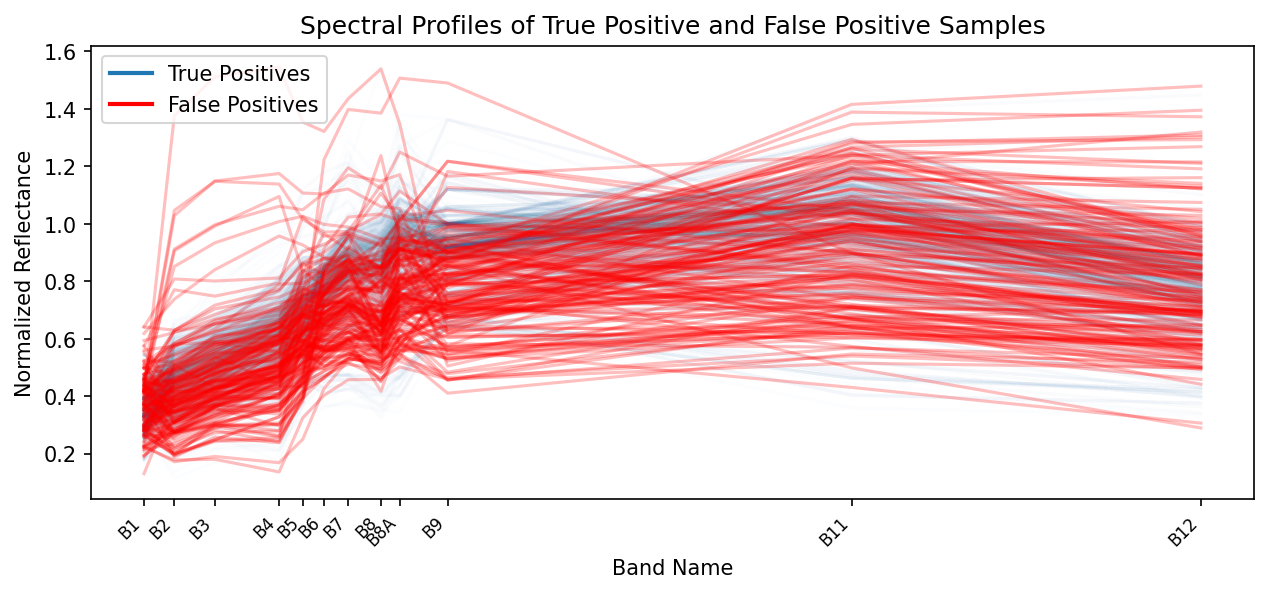

In [17]:
num_samples = 1000

plt.figure(figsize=(10,4), dpi=150, facecolor=(1,1,1))

for reflectance in inputs[tp_index][:num_samples]:
    plt.plot(band_wavelengths, reflectance, c='C0', alpha=0.01)
    
for reflectance in inputs[fp_index]:
    plt.plot(band_wavelengths, reflectance, c='r', alpha=0.25)

plt.xticks(band_wavelengths, band_descriptions.keys(), ha='right', rotation=45, size=8)
plt.xlabel('Band Name')
plt.ylabel('Normalized Reflectance')
    
legend_lines = [Line2D([0], [0], color='C0', lw=2),
                Line2D([0], [0], color='r', lw=2)]
plt.legend(legend_lines, ['True Positives', 'False Positives'], loc='upper left')

plt.title('Spectral Profiles of True Positive and False Positive Samples')
plt.show()

## What do correctly and incorrectly classified pixels look like?

### Scatterplot representation of category pixel colors

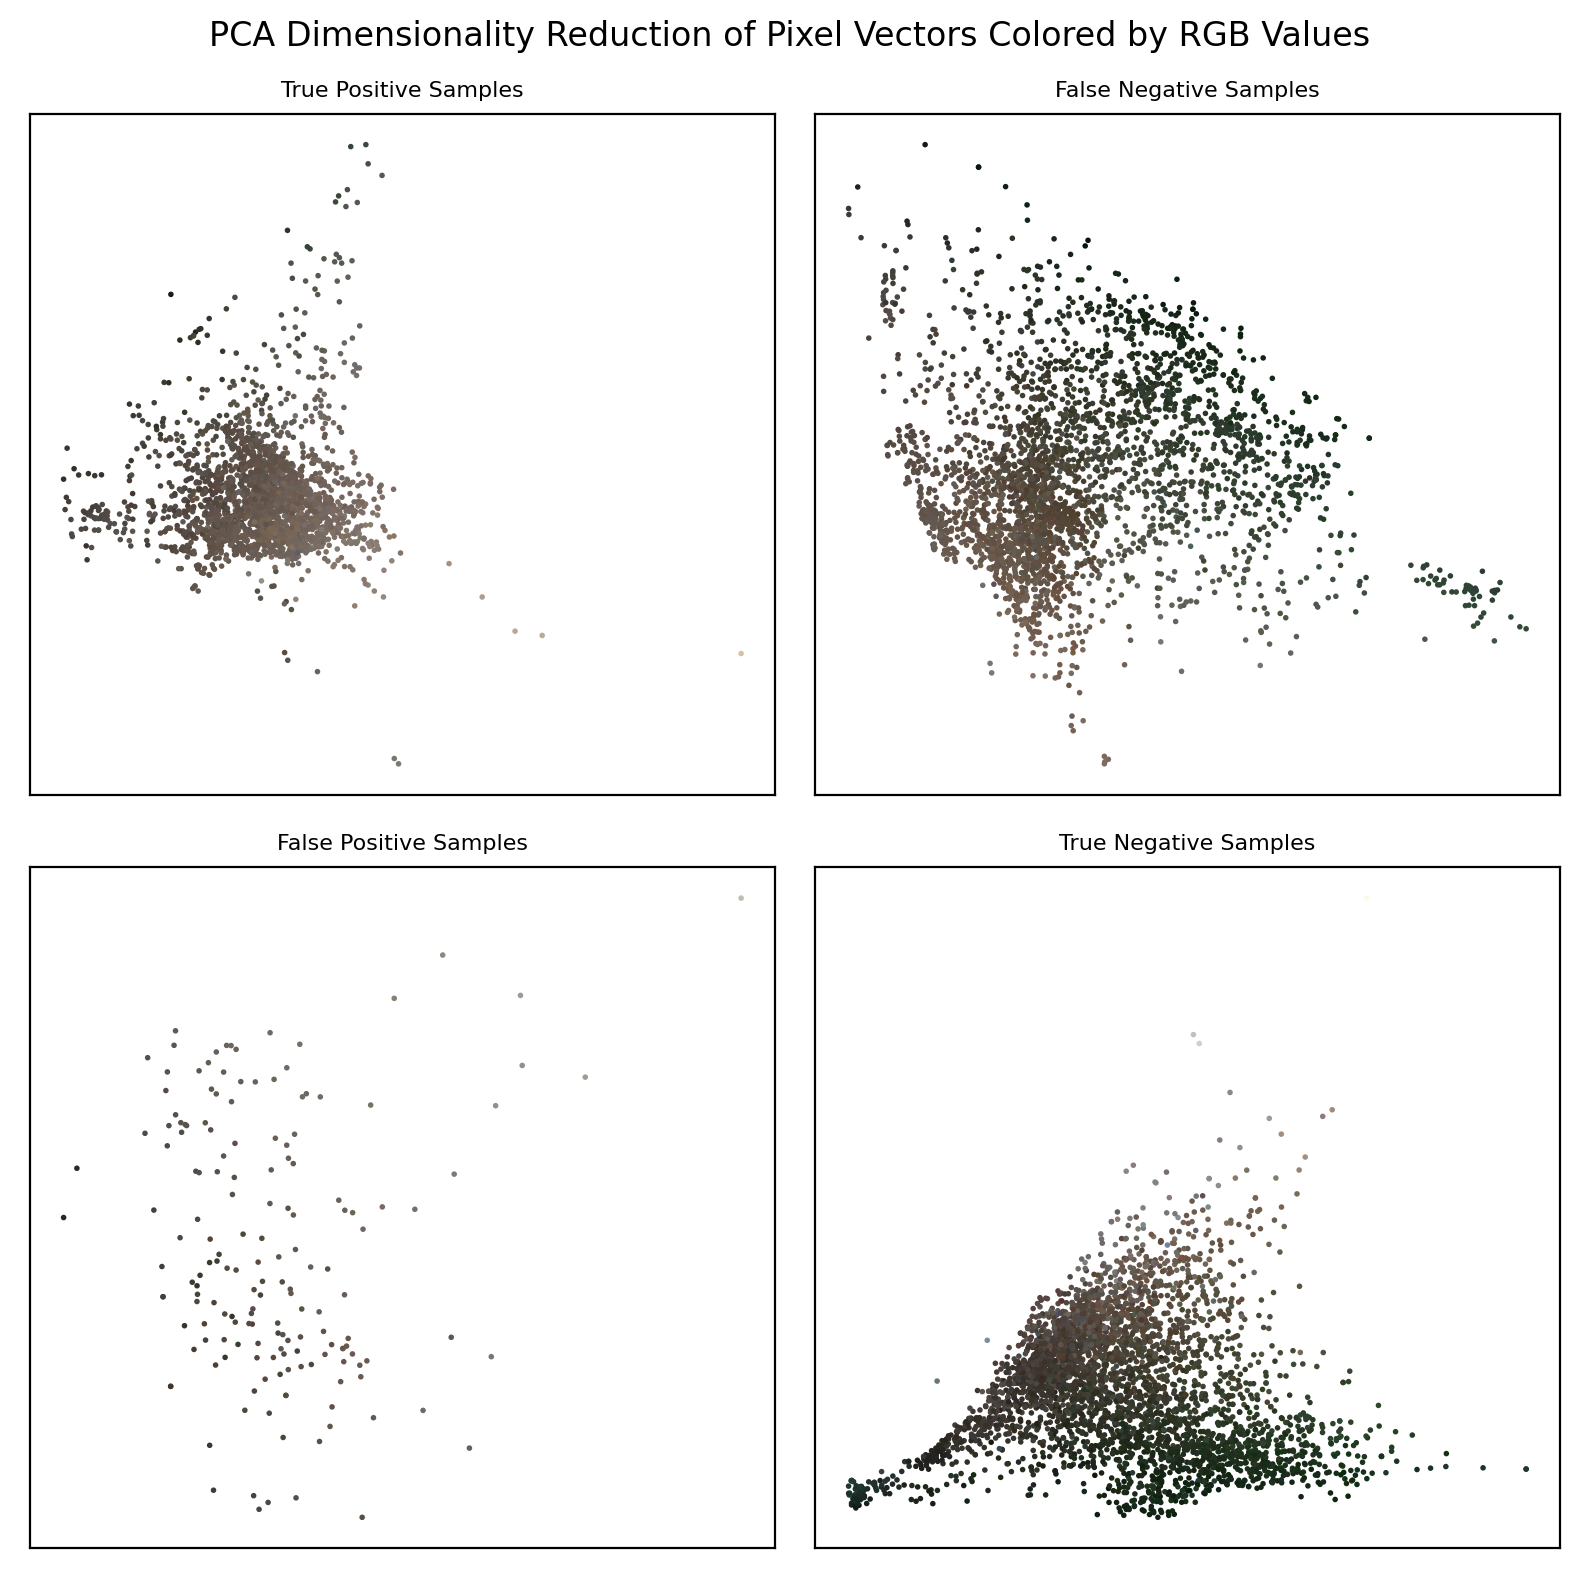

In [18]:
from sklearn.decomposition import PCA

point_size = 1
gamma = 0.65

plt.figure(figsize=(8,8), dpi=200, facecolor=(1,1,1))
plt.subplot(2,2,1)
pca = PCA(n_components=2)
pca_out = pca.fit_transform(np.squeeze(inputs[tp_index]))
plt.scatter(pca_out[:,0], pca_out[:,1], c=rgb[tp_index][:,0,0,:] ** gamma, s=point_size)
plt.xticks([])
plt.yticks([])
plt.title('True Positive Samples', size=8)

plt.subplot(2,2,2)
pca = PCA(n_components=2)
pca_out = pca.fit_transform(np.squeeze(inputs[fn_index]))
plt.scatter(pca_out[:,0], pca_out[:,1], c=rgb[fn_index][:,0,0,:] ** gamma, s=point_size)
plt.xticks([])
plt.yticks([])
plt.title('False Negative Samples', size=8)

plt.subplot(2,2,3)
pca = PCA(n_components=2)
pca_out = pca.fit_transform(np.squeeze(inputs[fp_index]))
plt.scatter(pca_out[:,0], pca_out[:,1], c=rgb[fp_index][:,0,0,:] ** gamma, s=point_size)
plt.xticks([])
plt.yticks([])
plt.title('False Positive Samples', size=8)


plt.subplot(2,2,4)
pca = PCA(n_components=2)
pca_out = pca.fit_transform(np.squeeze(inputs[tn_index]))
plt.scatter(pca_out[:,0], pca_out[:,1], c=rgb[tn_index][:,0,0,:] ** gamma, s=point_size)
plt.xticks([])
plt.yticks([])
plt.title('True Negative Samples', size=8)

plt.suptitle('PCA Dimensionality Reduction of Pixel Vectors Colored by RGB Values')
plt.tight_layout()
plt.show()

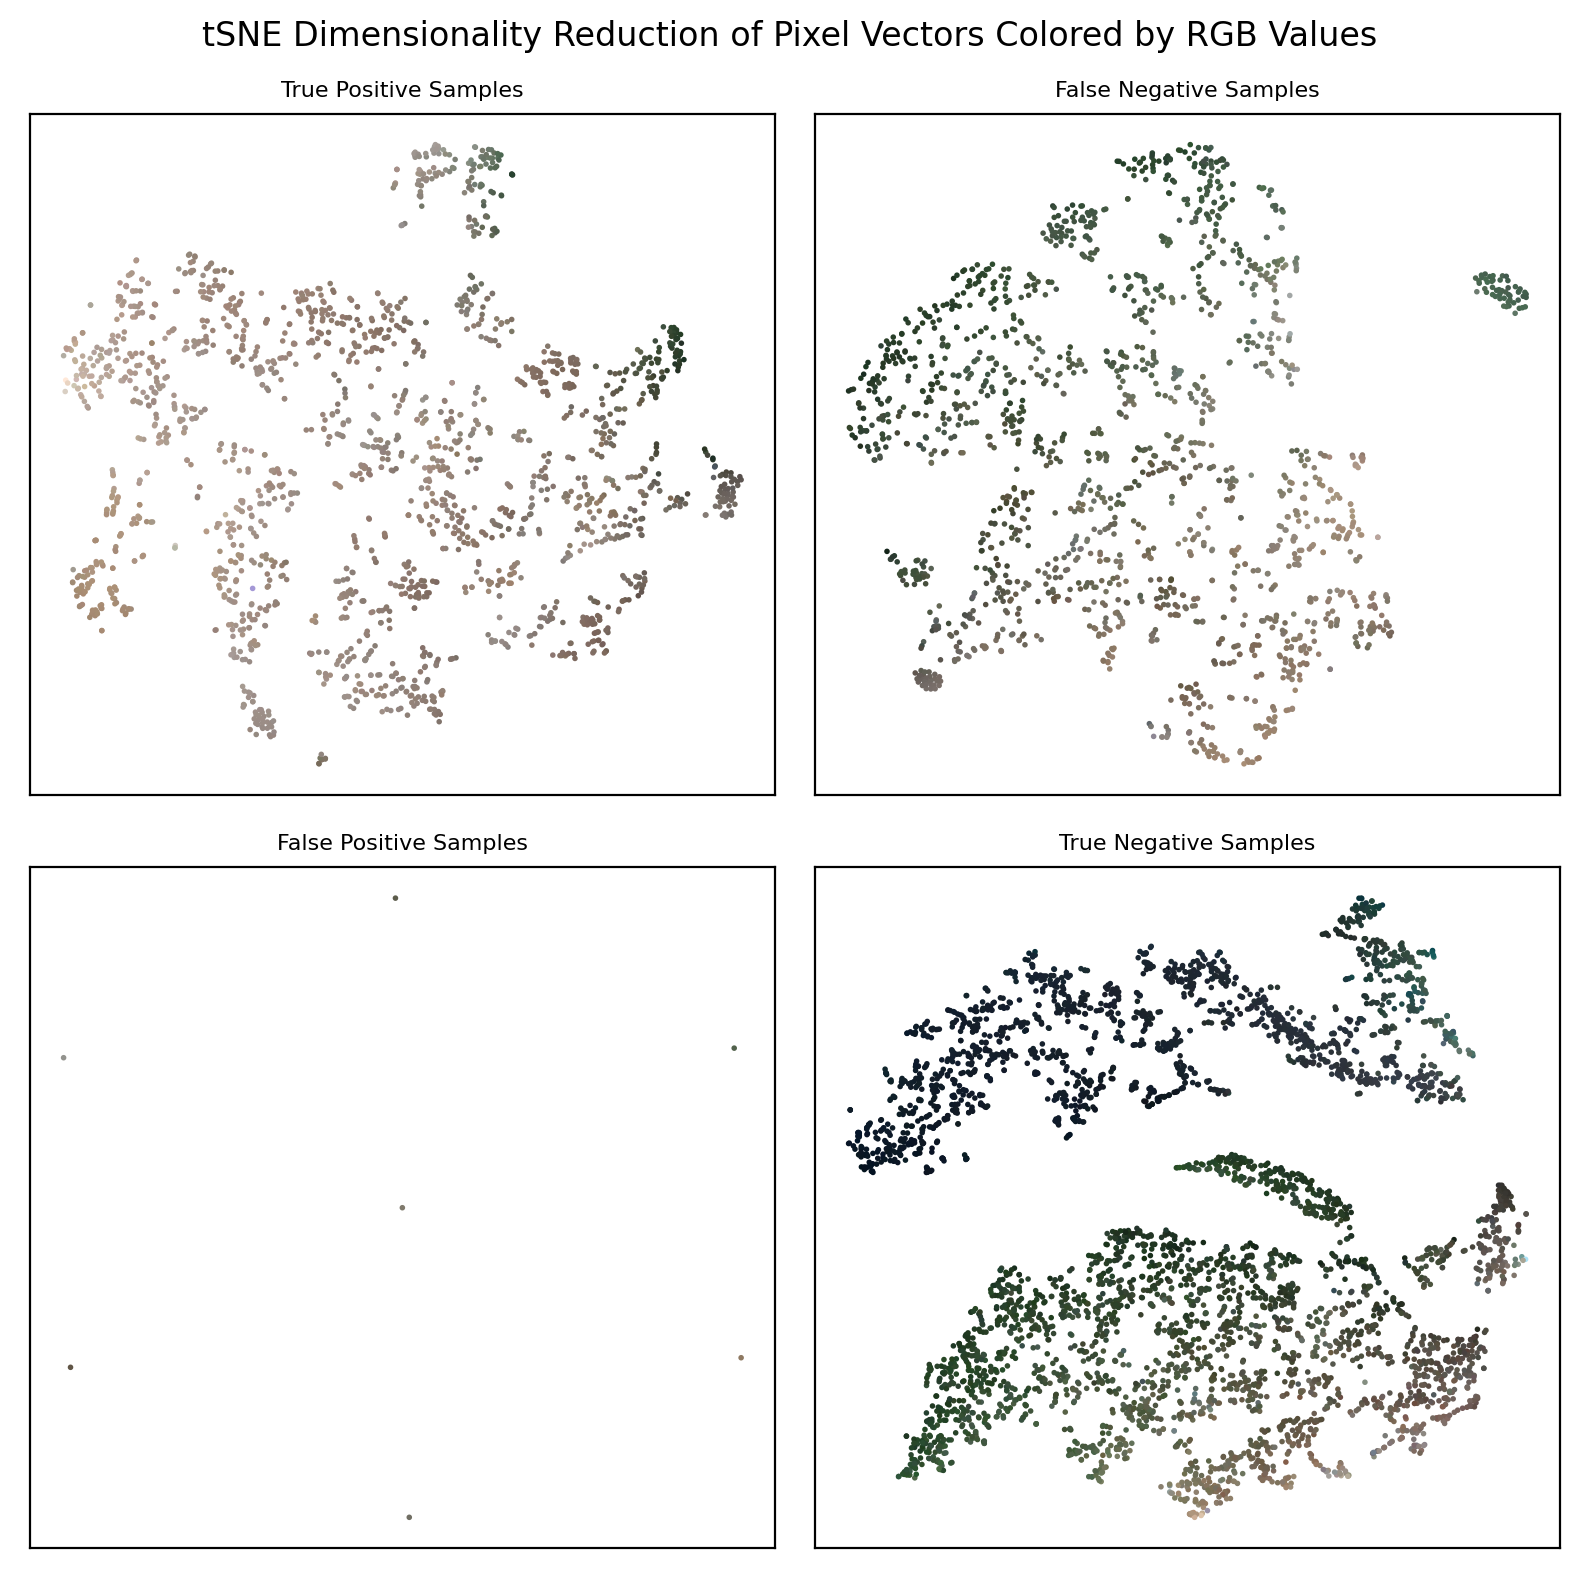

In [33]:
from sklearn.manifold import TSNE

plt.figure(figsize=(8,8), dpi=200, facecolor=(1,1,1))
plt.subplot(2,2,1)
tsne = TSNE(n_components=2)
tsne_out = tsne.fit_transform(np.squeeze(inputs[tp_index]))
plt.scatter(tsne_out[:,0], tsne_out[:,1], c=rgb[tp_index][:,0,0,:] ** gamma, s=point_size)
plt.xticks([])
plt.yticks([])
plt.title('True Positive Samples', size=8)

plt.subplot(2,2,2)
tsne = TSNE(n_components=2)
tsne_out = tsne.fit_transform(np.squeeze(inputs[fn_index]))
plt.scatter(tsne_out[:,0], tsne_out[:,1], c=rgb[fn_index][:,0,0,:] ** gamma, s=point_size)
plt.xticks([])
plt.yticks([])
plt.title('False Negative Samples', size=8)

plt.subplot(2,2,3)
tsne = TSNE(n_components=2)
tsne_out = tsne.fit_transform(np.squeeze(inputs[fp_index]))
plt.scatter(tsne_out[:,0], tsne_out[:,1], c=rgb[fp_index][:,0,0,:] ** gamma, s=point_size)
plt.xticks([])
plt.yticks([])
plt.title('False Positive Samples', size=8)


plt.subplot(2,2,4)
tsne = TSNE(n_components=2)
tsne_out = tsne.fit_transform(np.squeeze(inputs[tn_index]))
plt.scatter(tsne_out[:,0], tsne_out[:,1], c=rgb[tn_index][:,0,0,:] ** gamma, s=point_size)
plt.xticks([])
plt.yticks([])
plt.title('True Negative Samples', size=8)

plt.suptitle('tSNE Dimensionality Reduction of Pixel Vectors Colored by RGB Values')
plt.tight_layout()
plt.show()

### Visualize pixel colors directly

In [39]:
def plot_pixel_grid(preds, colors, title):
    plt.figure(figsize=(20,20), dpi=50, facecolor=(1,1,1))
    num_samples = np.min([len(preds), 100])
    indices = np.random.choice(len(preds), num_samples)
    for i in range(num_samples):
        index = indices[i]
        pred = preds[index]
        rgb = colors[index] ** gamma
        plt.subplot(10,10,i + 1)
        plt.imshow(rgb)
        plt.axis('off')
        plt.title(f"{pred[1]:.2f}")
    plt.suptitle(title, size=40, y=1.01)
    plt.tight_layout()
    plt.show()

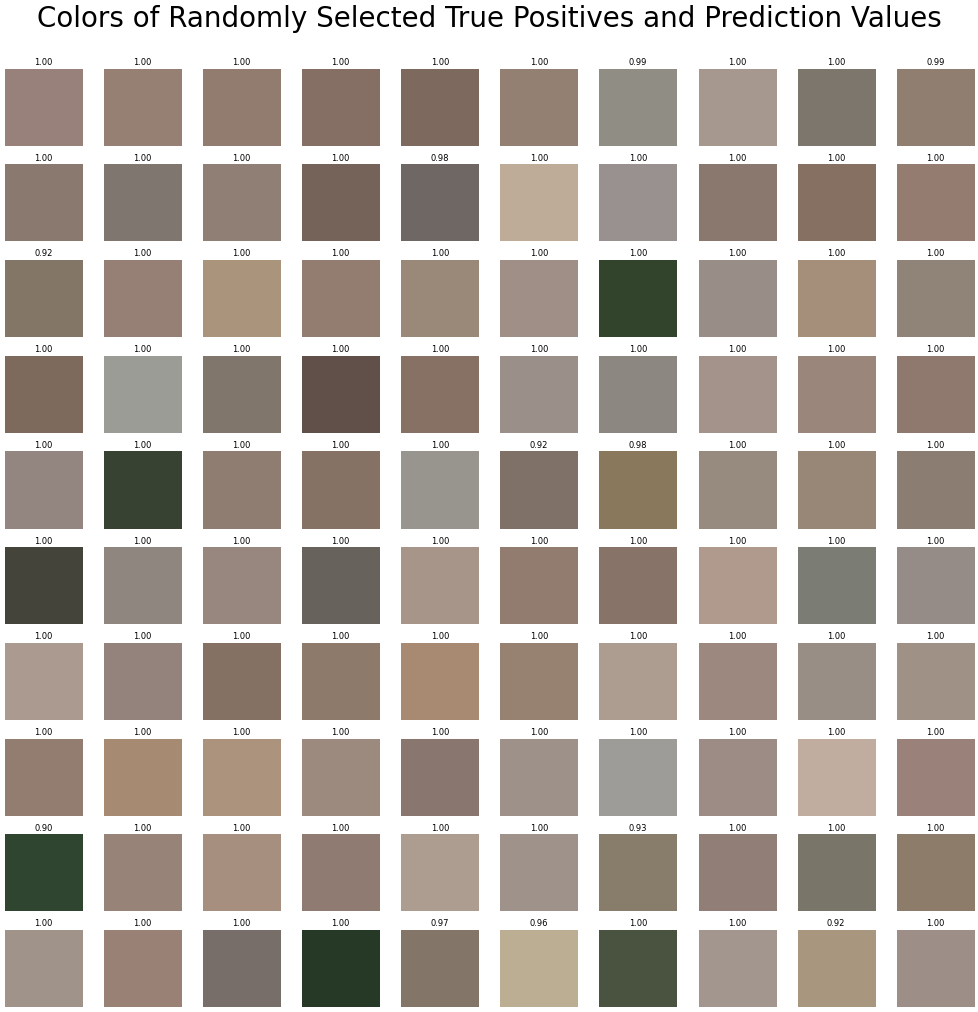

In [40]:
plot_pixel_grid(preds[tp_index], rgb[tp_index], 'Colors of Randomly Selected True Positives and Prediction Values')

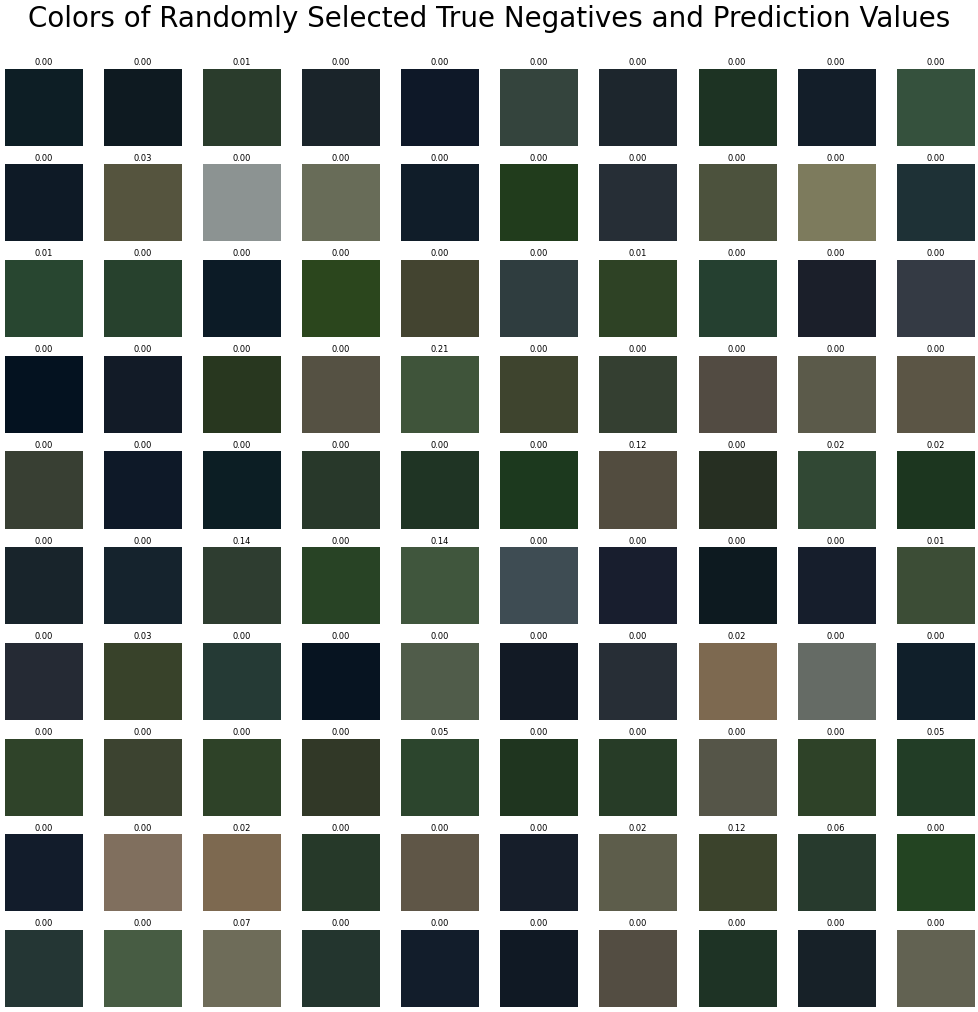

In [41]:
plot_pixel_grid(preds[tn_index], rgb[tn_index], 'Colors of Randomly Selected True Negatives and Prediction Values')

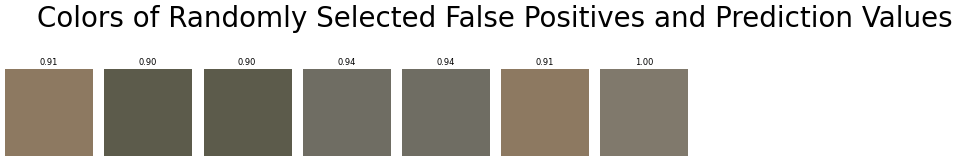

In [42]:
plot_pixel_grid(preds[fp_index], rgb[fp_index], 'Colors of Randomly Selected False Positives and Prediction Values')

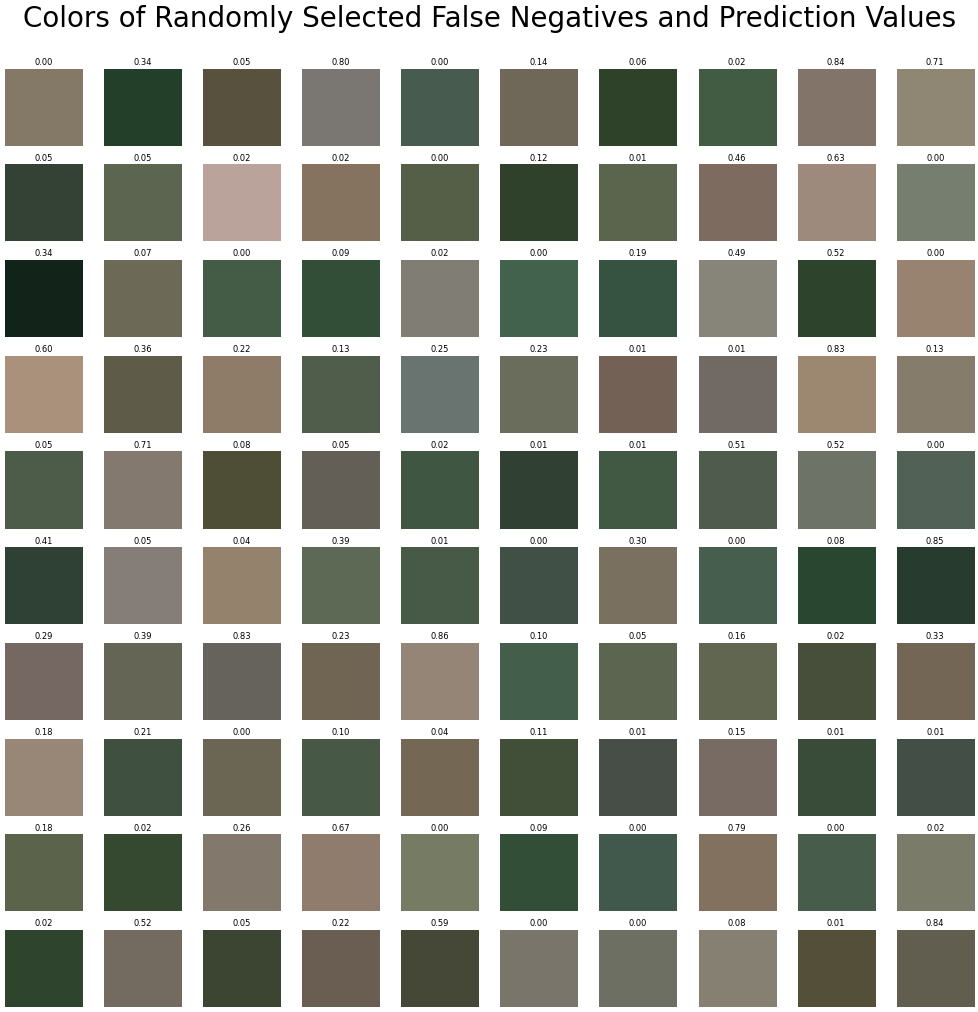

In [43]:
plot_pixel_grid(preds[fn_index], rgb[fn_index], 'Colors of Randomly Selected False Negatives and Prediction Values')

## Prototype Pixel Visualization

In [27]:
data_dir = '../data/training_sites'

with open(os.path.join(data_dir, "tpa_patch_histories.pkl"), 'rb') as file:
    history = pickle.load(file)

In [43]:
temesi = history['2019-06-01']['TPA Temesi']

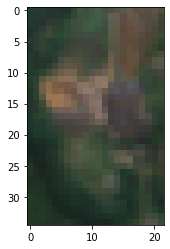

In [83]:
rgb = np.stack((temesi['B4'], 
                temesi['B3'],
                temesi['B2']), axis=2)
plt.imshow(rgb / 3000)
plt.show()

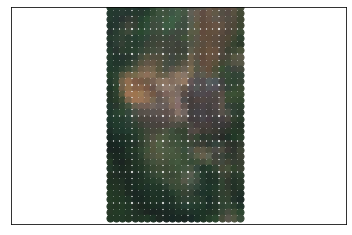

In [82]:
for i in range(rgb.shape[0]):
    for j in range(rgb.shape[1]):
        plt.scatter(j, rgb.shape[0] - i, color=rgb[i,j] / 3000, s=50)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlim((0, rgb.shape[1]))
plt.ylim((0, rgb.shape[0]))
#plt.tight_layout()
plt.show()

In [180]:
pixel_vectors = []
for i in range(rgb.shape[0]):
    for j in range(rgb.shape[1]):
        pixel_vector = []
        for band in band_descriptions:
            pixel_vector.append(temesi[band][i][j])
        pixel_vectors.append(pixel_vector)
pixel_vectors = np.array(pixel_vectors)

In [181]:
model = keras.models.load_model('../models/model_filtered-12-07-2020.h5')
preds = model.predict(np.expand_dims(pixel_vectors, axis=-1) / 3000)[:,1]

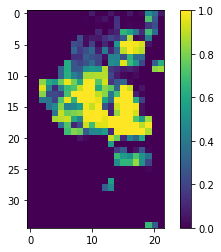

In [284]:
plt.imshow(np.reshape(preds, (rgb.shape[0], rgb.shape[1])), vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [329]:
from sklearn.manifold import TSNE
pca = TSNE(n_components=1)
pca_out = pca.fit_transform(pixel_vectors)

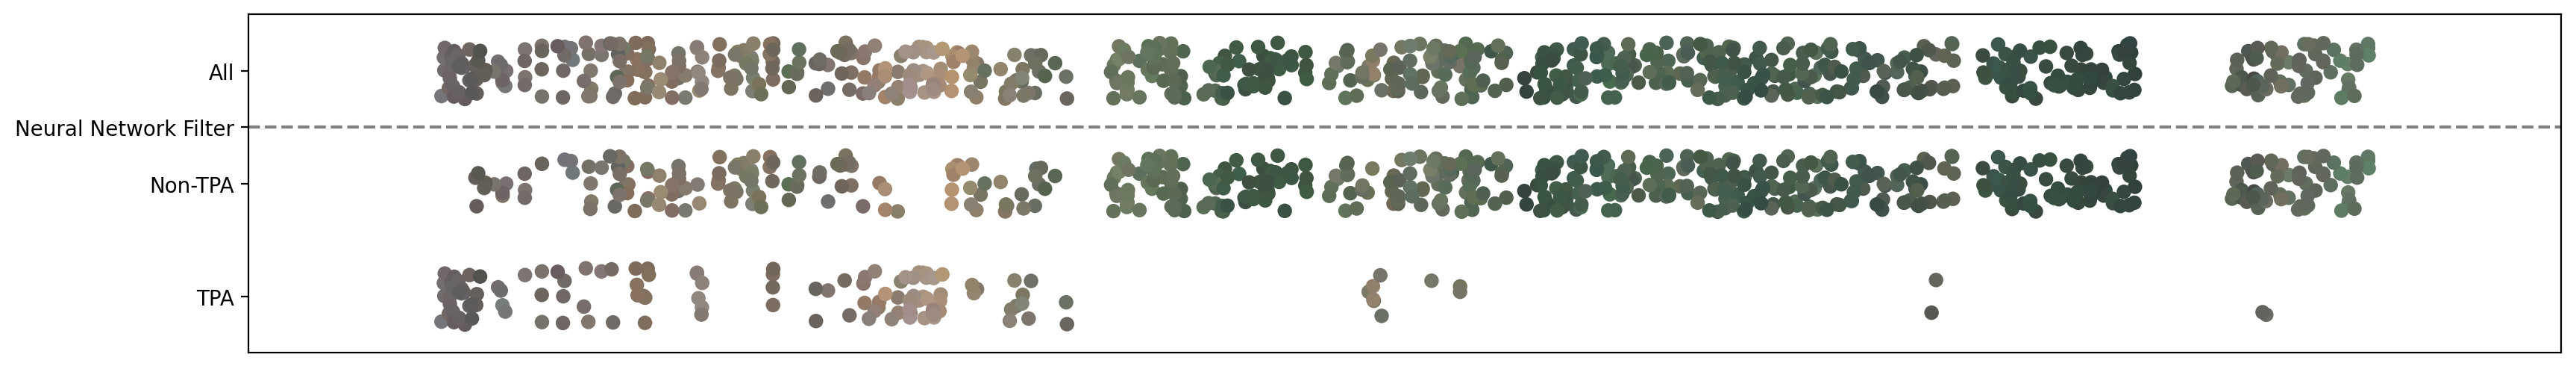

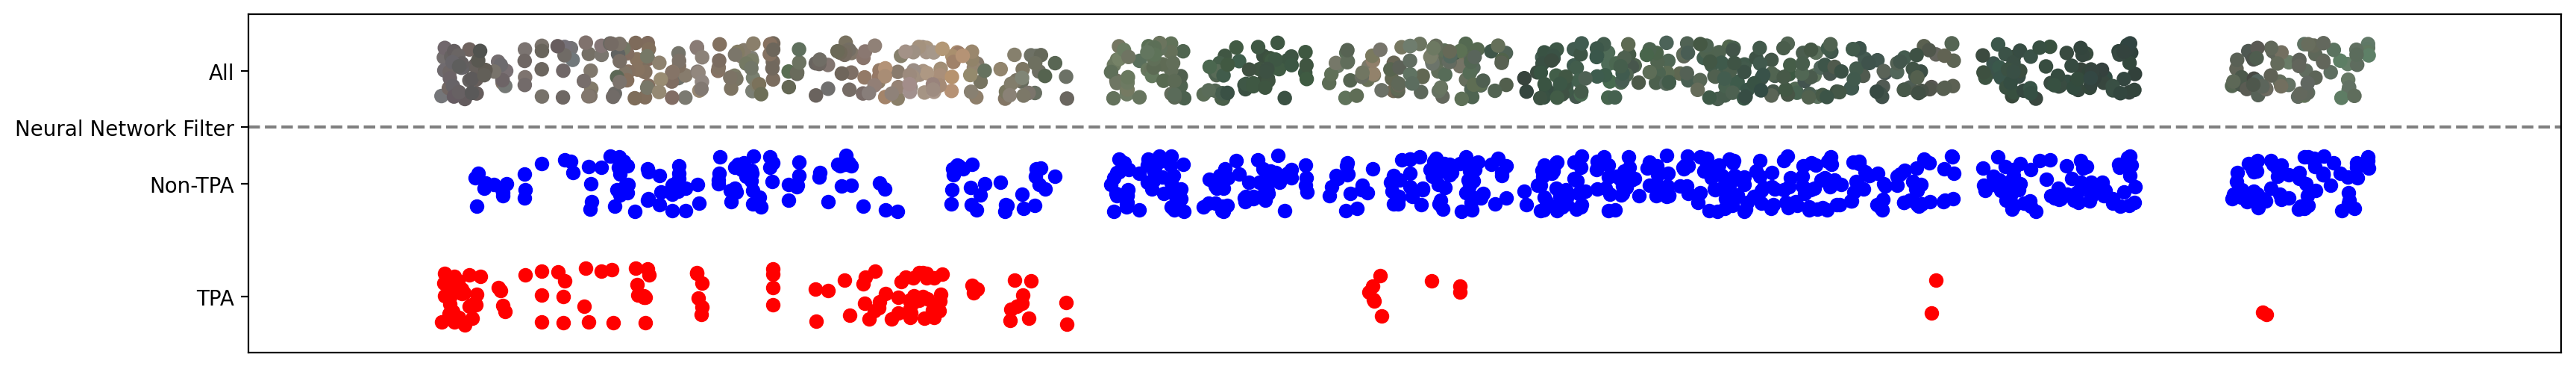

In [330]:
gamma = 0.7
r = (np.clip(pixel_vectors[:,3], None, 3000) / 3000) ** gamma
g = (np.clip(pixel_vectors[:,2], None, 3000) / 3000) ** gamma
b = (np.clip(pixel_vectors[:,1], None, 3000) / 3000) ** gamma

pixel_rgb = np.stack((r,g,b), axis = 1)
pca_range = pca_out.max() - pca_out.min()

threshold = 0.6
plt.figure(figsize=(20, 3), dpi=200)
offset = (np.random.random(len(pca_out)) - 0.5) / 2
plt.scatter(pca_out[preds > threshold], offset[preds > threshold] + 0, color=pixel_rgb[preds > threshold])
plt.plot([pca_out.min() - 0.1 * pca_range, pca_out.max() + 0.1 * pca_range], [1.5, 1.5], '--', color='gray')
plt.scatter(pca_out[preds <= threshold], offset[preds <= threshold] + 1, color=pixel_rgb[preds <= threshold])
plt.scatter(pca_out, offset + 2, color=pixel_rgb)
plt.xticks([])
plt.yticks([0, 1, 1.5, 2], ['TPA', 'Non-TPA', 'Neural Network Filter', 'All'])
plt.xlim([pca_out.min() - 0.1 * pca_range, 
          pca_out.max() + 0.1 * pca_range])
plt.ylim([-0.5, 2.5])
plt.show()

plt.figure(figsize=(20, 3), dpi=200)
plt.scatter(pca_out[preds > threshold], offset[preds > threshold] + 0, c='r')
plt.plot([pca_out.min() - 0.1 * pca_range, pca_out.max() + 0.1 * pca_range], [1.5, 1.5], '--', color='gray')
plt.scatter(pca_out[preds <= threshold], offset[preds <= threshold] + 1, c='b')
plt.scatter(pca_out, offset + 2, color=pixel_rgb)
plt.xticks([])
plt.yticks([0, 1, 1.5, 2], ['TPA', 'Non-TPA', 'Neural Network Filter', 'All'])
plt.xlim([pca_out.min() - 0.1 * pca_range, 
          pca_out.max() + 0.1 * pca_range])
plt.ylim([-0.5, 2.5])
plt.show()

In [371]:
x = []
y = []
for i in range(rgb.shape[0]):
    for j in range(rgb.shape[1]):
        x.append(j)
        y.append(i)

In [400]:
rgb.shape[0]

35

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


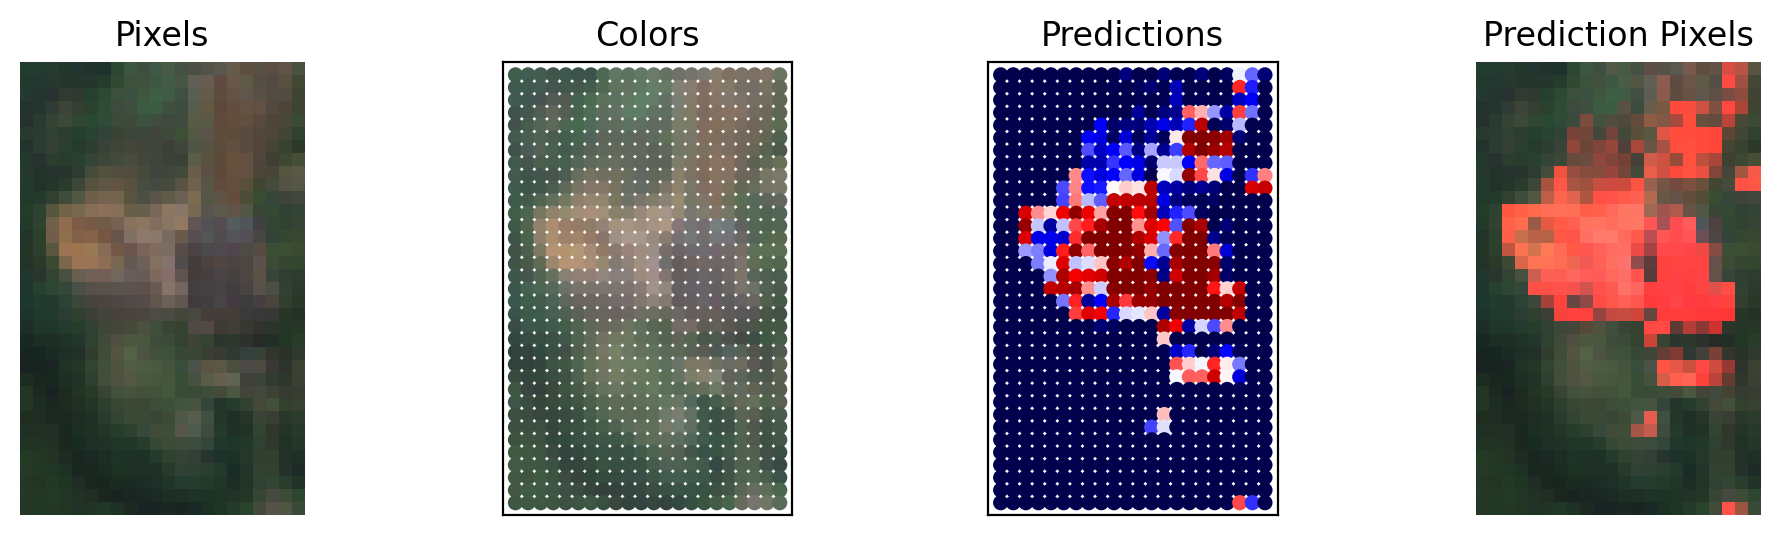

In [426]:
rgb = np.stack((temesi['B4'], 
                temesi['B3'],
                temesi['B2']), axis=2)

plt.figure(figsize=(12, 3), dpi=200)
plt.subplot(1,4,1)
plt.imshow(rgb / 3000)
plt.axis('off')
plt.title('Pixels')


plt.subplot(1,4,2)
plt.scatter(x, rgb.shape[0] - np.array(y), c=pixel_rgb, cmap='seismic', s=20)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.ylim([0, rgb.shape[0] + 1])
plt.xlim([-1, rgb.shape[1]])
plt.title('Colors')

plt.subplot(1,4,3)
plt.scatter(x, rgb.shape[0] - np.array(y), c=preds, cmap='seismic', s=20)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.ylim([0, rgb.shape[0] + 1])
plt.xlim([-1, rgb.shape[1]])
plt.title('Predictions')

plt.subplot(1,4,4)
preds_img = np.reshape(preds, (rgb.shape[0], rgb.shape[1]))
overlay = np.copy(rgb) / 3000
overlay[:,:,0] += preds_img
plt.imshow(overlay, vmin=0, vmax=1)
plt.axis('off')
plt.title('Prediction Pixels')

plt.show()

(35, 22, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


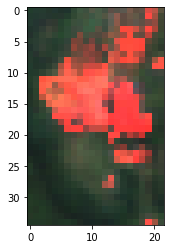

In [388]:
preds_img = np.reshape(preds, (rgb.shape[0], rgb.shape[1]))
overlay = np.copy(rgb) / 3000
overlay[:,:,0] += preds_img
plt.imshow(overlay, vmin=0, vmax=1)
#plt.imshow(preds_img, cmap='Reds', vmin=0, vmax=1, alpha=0.3)
plt.show()